In [1]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import neurokit2 as nk
import heartpy as hp
from statistics import mean
import functions
from multiprocessing import Pool
from datetime import time
import functions
import scipy
import math
import operator
from functions import *
import itertools
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
folder = ""
raw = folder + "raw_data/"
x_train = pd.read_csv('x_train_preprocess.csv')
x_test = pd.read_csv('x_test_preprocess.csv')
y_train = pd.read_csv(raw + 'y_train.csv', index_col=['id'])

x_train = x_train.fillna(0)
x_test = x_test.fillna(0)
np.isinf(x_train).values.sum()



0

In [3]:
col_name = x_train.columns.to_series()[np.isinf(x_train).any()]
col_name

Series([], dtype: object)

In [4]:
#anomaly detection with isolation forest with scores
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=200, random_state=1733979241)
clf.fit(x_train)
y_pred_train = clf.predict(x_train)
scores = clf.decision_function(x_train)
#count anomalies
anomalies = 0
for i in y_pred_train:
    if i == -1:
        anomalies += 1
print(anomalies)
#remove anomalies
#x_train = x_train[y_pred_train == 1]
#y_train = y_train[y_pred_train == 1]   


182


In [5]:
scores = pd.DataFrame(scores , columns = ['scores'])
#print scores higher than 0.7
max(scores['scores'])

0.15573617815165647

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Columns: 1074 entries, Unnamed: 0.1 to 63
dtypes: float64(1071), int64(3)
memory usage: 41.9 MB


In [7]:
#save feature name
feature_name = x_train.columns

In [8]:
selector = SelectKBest(score_func=f_classif, k=925)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols = selector.get_support(indices=True)

C:\Users\david\anaconda3\envs\preprocessing.ipynb\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [73] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


In [9]:
x_train= x_train.iloc[:,cols]
x_test = x_test.iloc[:,cols]

In [10]:
#scale data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [11]:
#random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state=1733979241)

In [12]:
import pickle
filename = 'models/random_forest_model.sav'
pickle.dump(clf, open(filename, 'wb'))


In [13]:
stop;

NameError: name 'stop' is not defined

In [ ]:
#cross validation score
scores = cross_val_score(clf, x_train, np.ravel(y_train), cv=10, scoring='f1_micro',n_jobs=-1)
print(scores.mean())
print(scores.std())
#0.6880920529598826 / 0.01306019561569018 MinMaxScaler
#0.6912193462573386 / 0.011284110708011923 new preprocessing
#0.6984512597847358 / 0.012100579167071735 new new preprocessing
#0.6990349039872799 / 0.009122000817677589 378 nk feat
#0.7736909093688845 / 0.01017577556042029 1009 feat
#0.7791619526663405 / 0.008659228728196107 950 feat
#0.7758412579500978 / 0.01054161411455059 850 feat
#0.7774033757338552 / 0.011964939066628696 900 feat
#0.7762341762475538 / 0.00917907789442495 975 feat
#0.7758378180039138 / 0.016074265927511638 925 feat


In [13]:
clf.fit(x_train, np.ravel(y_train))

RandomForestClassifier(n_estimators=300, random_state=1733979241)

In [ ]:
#feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_name[indices[f]], importances[indices[f]]))
    

In [14]:
y_test = clf.predict(x_test)
data_y_test = {
    'id': [i for i in range(len(y_test))],
    'y': y_test
}
df_y_test = pd.DataFrame(data_y_test)
df_y_test.to_csv('outputs/output_random_forest.csv', index=False)

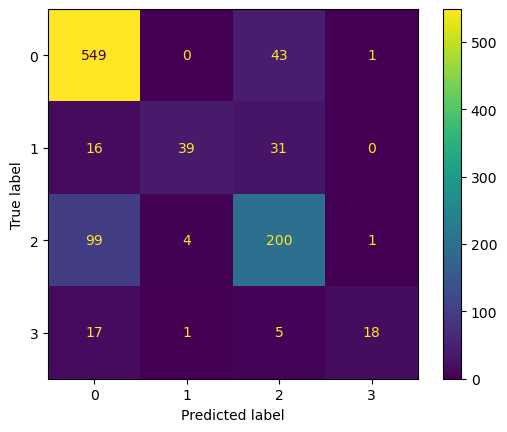

In [29]:
#obtain validation set
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1733979241)
clf.fit(x_train_2, np.ravel(y_train_2))
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
y_pred = clf.predict(x_val)
cm = metrics.confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()